In [0]:
! apt-get install protobuf-compiler python-pil python-lxml python-tk
! pip install Cython
! git clone https://github.com/tensorflow/models.git

%cd /content/models/research

!protoc object_detection/protos/*.proto --python_out=.

%set_env PYTHONPATH=/content/models/research:/content/models/research/slim

! python object_detection/builders/model_builder_test.py

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
python-tk is already the newest version (2.7.16-2~18.04).
The following additional packages will be installed:
  python-bs4 python-chardet python-html5lib python-olefile
  python-pkg-resources python-six python-webencodings
Suggested packages:
  python-genshi python-lxml-dbg python-lxml-doc python-pil-doc python-pil-dbg
  python-setuptools
The following NEW packages will be installed:
  python-bs4 python-chardet python-html5lib python-lxml python-olefile
  python-pil python-pkg-resources python-six python-webencodings
0 upgraded, 9 newly installed, 0 to remove and 35 not upgraded.
Need to get 1,818 kB of archives.
After this operation, 7,688 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python-bs4 all 4.6.0-1 [67.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd

In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.9.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.9.* or later!')

In [0]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [0]:
### Upload do modelo treinado

# S:\DComercial\Atendimento_Cliente\Processos_Comerciais\Supervisao\DataScience\Nossos Projetos e Demandas\Estruturados\____Contagem_IP

import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
from zipfile import ZipFile
import os

## Modelo pré-treinado para ser subido
FILE_ID = '1gfOYXnysV9Tuj2Mc3Agc2E1REuTNVryK'
download = drive.CreateFile({'id': FILE_ID})
download.GetContentFile('/content/inference_graph.zip')

with ZipFile('/content/inference_graph.zip', 'r') as zipObj:
   zipObj.extractall('/content/')

! rm /content/inference_graph.zip

In [0]:
# Upload dos conteúdos de training/labelmap.pbtxt
os.chdir('/content')
# S:\DComercial\Atendimento_Cliente\Processos_Comerciais\Supervisao\DataScience\Nossos Projetos e Demandas\Estruturados\____Contagem_IP\TensorFlow_ObjectDetection\training
from google.colab import files
files.upload()


Saving faster_rcnn_inception_v2_pets.config to faster_rcnn_inception_v2_pets.config
Saving labelmap.pbtxt to labelmap.pbtxt


{'faster_rcnn_inception_v2_pets.config': b'# Faster R-CNN with Inception v2, configured for Oxford-IIIT Pets Dataset.\n# Users should configure the fine_tune_checkpoint field in the train config as\n# well as the label_map_path and input_path fields in the train_input_reader and\n# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that\n# should be configured.\n\nmodel {\n  faster_rcnn {\n    num_classes: 1\n    image_resizer {\n      keep_aspect_ratio_resizer {\n        min_dimension: 600\n        max_dimension: 1024\n      }\n    }\n    feature_extractor {\n      type: \'faster_rcnn_inception_v2\'\n      first_stage_features_stride: 16\n    }\n    first_stage_anchor_generator {\n      grid_anchor_generator {\n        scales: [0.25, 0.5, 1.0, 2.0]\n        aspect_ratios: [0.5, 1.0, 2.0]\n        height_stride: 16\n        width_stride: 16\n      }\n    }\n    first_stage_box_predictor_conv_hyperparams {\n      op: CONV\n      regularizer {\n        l2_regularize

In [0]:
import shutil
import os

if not os.path.exists('/content/training'):
    os.makedirs('/content/training')

shutil.move('/content/labelmap.pbtxt', '/content/training/')
shutil.move('/content/faster_rcnn_inception_v2_pets.config', '/content/training/')

'/content/training/faster_rcnn_inception_v2_pets.config'

In [0]:
MODEL_NAME = 'inference_graph'
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'
PATH_TO_LABELS = 'training/labelmap.pbtxt'

In [0]:
os.chdir('/content/')

In [0]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [0]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [0]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [0]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.int64)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [0]:
# This is needed to display the images.
%matplotlib inline

In [0]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
#PATH_TO_TEST_IMAGES_DIR = '/content/images/train/'
PATH_TO_TEST_IMAGES_DIR = '/content/images/experiment/'

if not os.path.exists(PATH_TO_TEST_IMAGES_DIR):
    os.makedirs(PATH_TO_TEST_IMAGES_DIR)

ListImg = [ fname for fname in os.listdir(PATH_TO_TEST_IMAGES_DIR) if fname.endswith('.jpg')]

TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR,img) for img in ListImg] 

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [0]:
# Imagens por URL

In [0]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

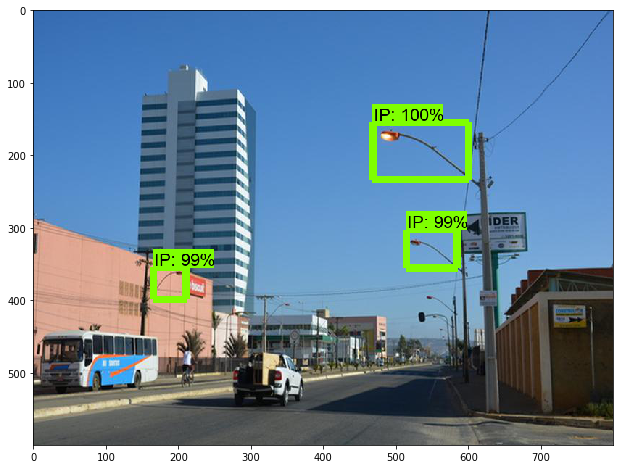

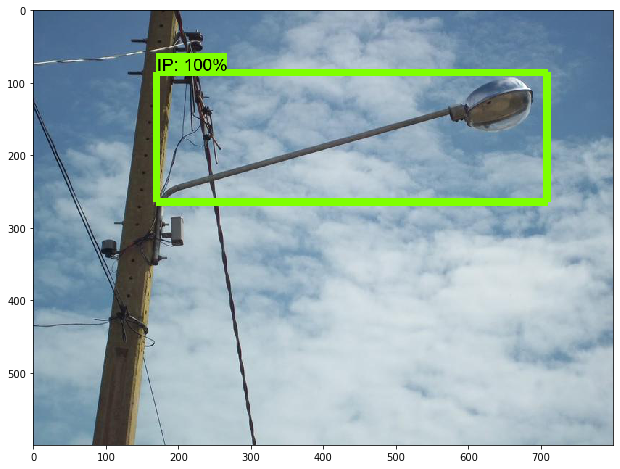

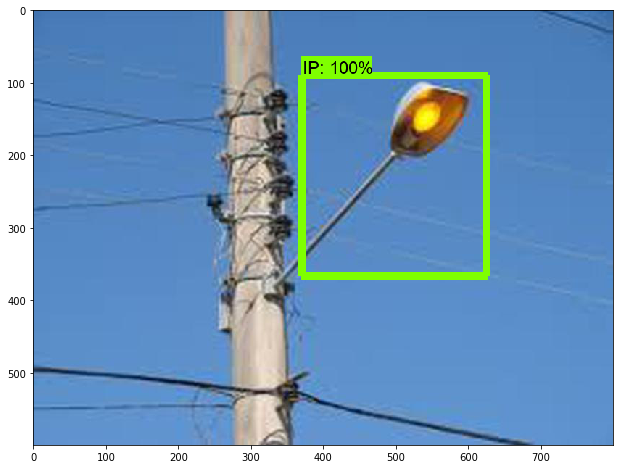

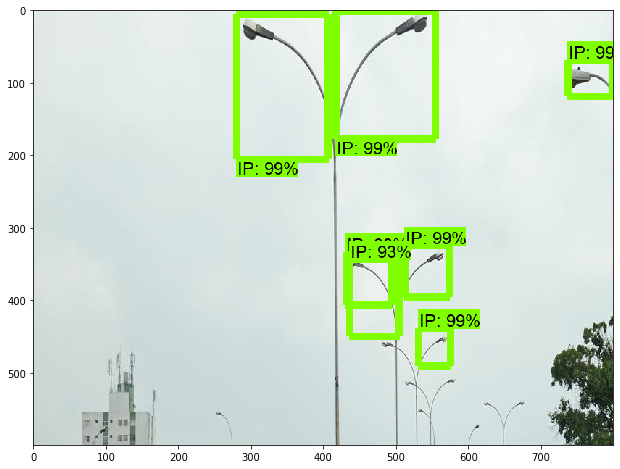

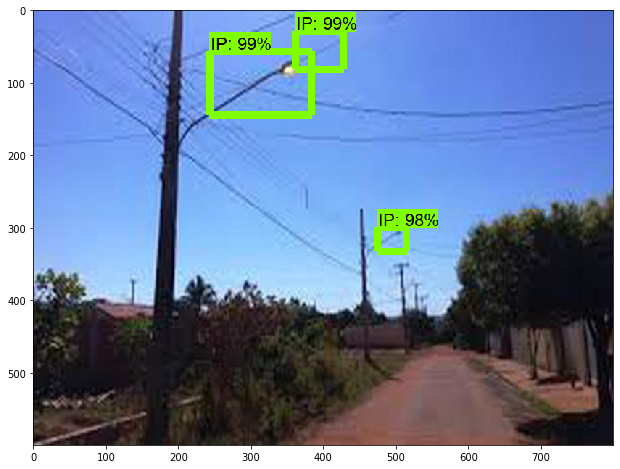

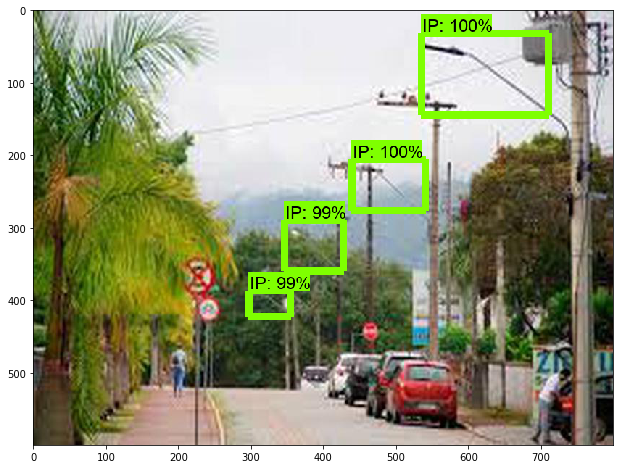

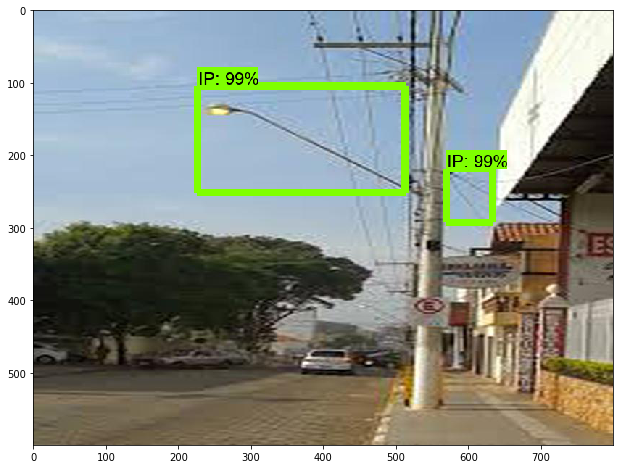

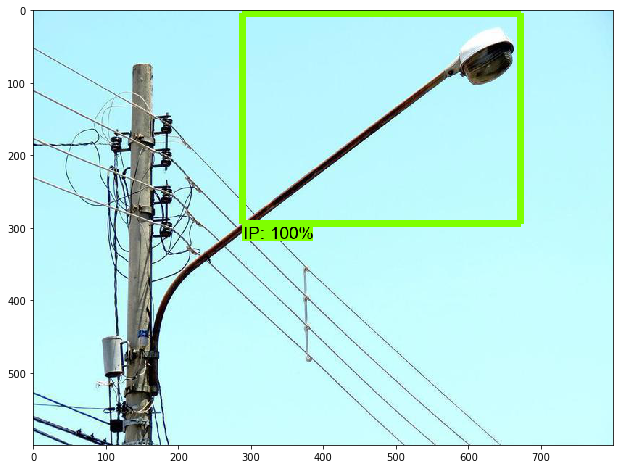

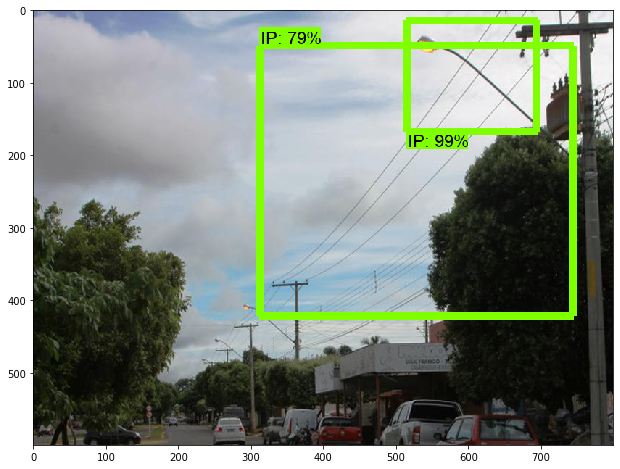

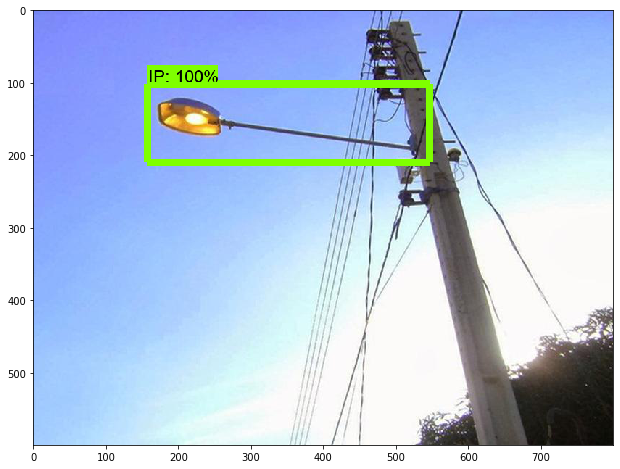

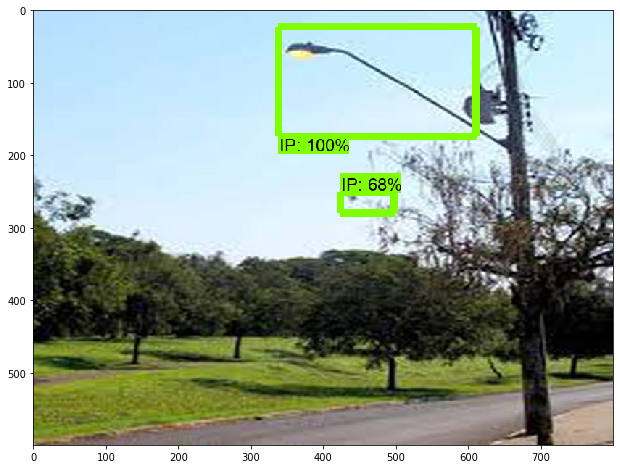

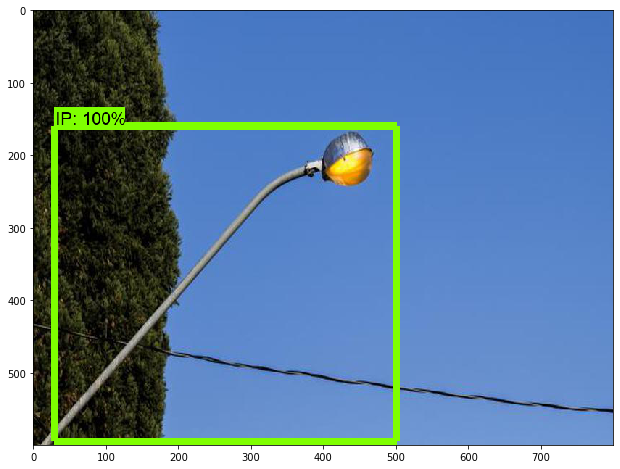

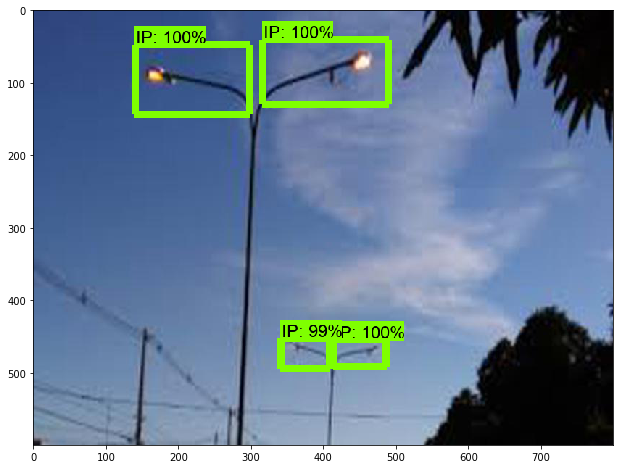

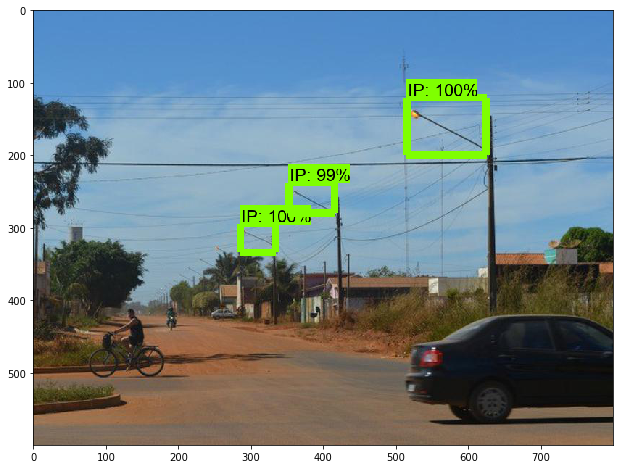

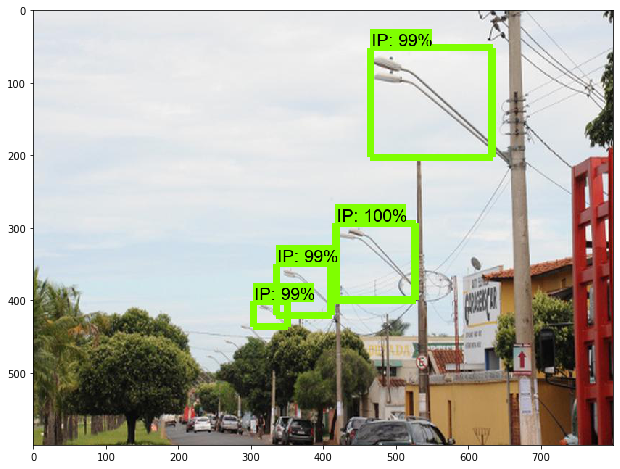

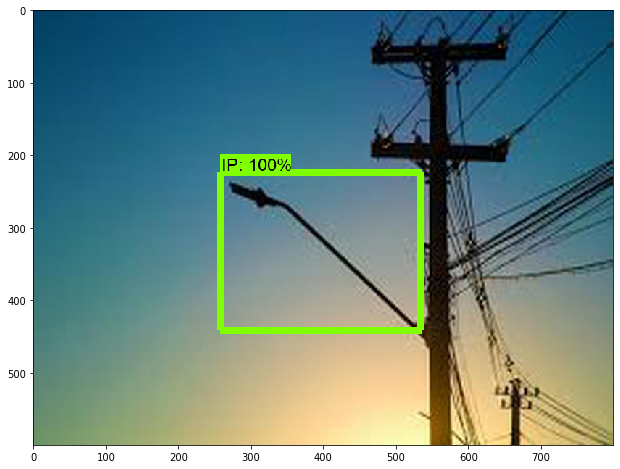

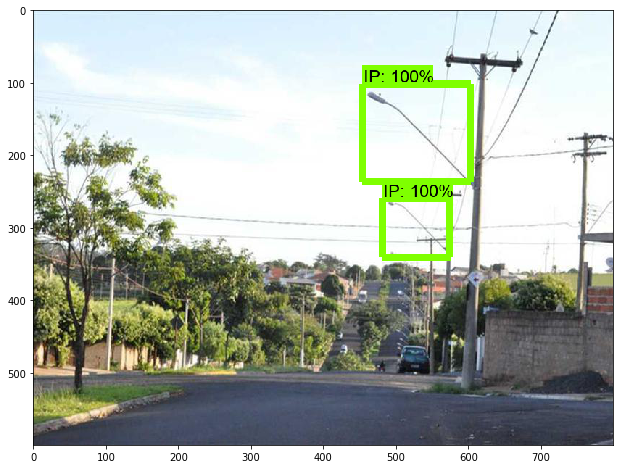

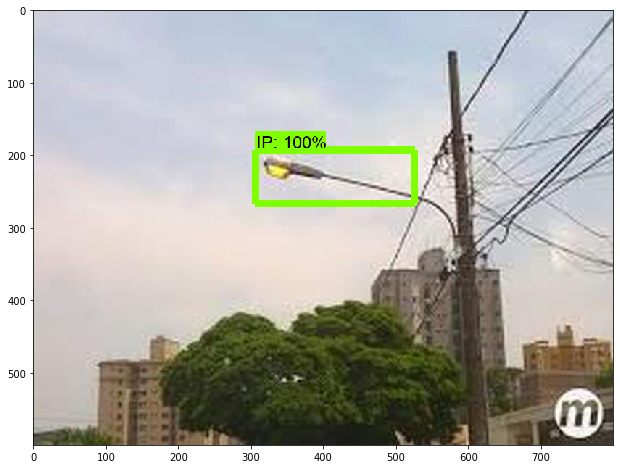

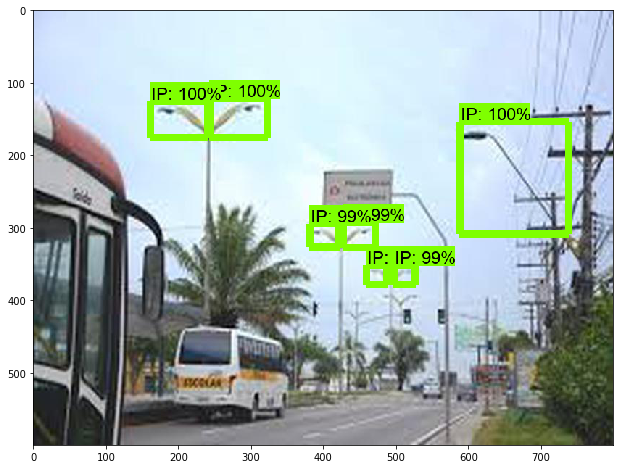

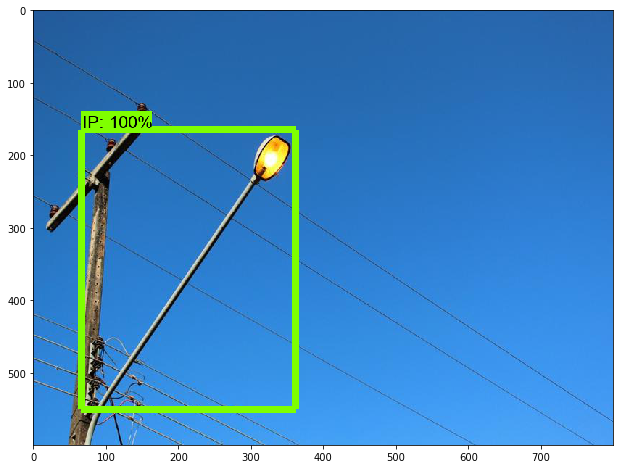

In [0]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=10)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)  